# 纯股债风险平价组合

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [88]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [89]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [90]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [91]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI,CBA00401.CS,CBA02701.CS,000300.SH,000905.SH,000906.SH,000921.CSI,H00804.CSI
2019-02-28,3928.2468,28633.18,2784.49,189.3338,286.02,66.28,1517.4788,1076.2718,187.0680,176.1590,3669.3703,5025.2913,3889.8856,3968.6833,12281.1598
2019-03-01,3988.7126,28812.17,2803.69,189.2418,284.49,65.00,1517.5963,1094.3259,186.9298,176.1300,3749.7143,5067.2250,3962.3652,4061.7369,12399.5331
2019-03-04,4052.0983,28959.59,2792.81,189.2119,280.71,65.55,1517.9392,1085.7210,186.8968,176.0778,3794.1040,5158.2467,4015.0568,4103.4113,12623.9701
2019-03-05,4118.7246,28961.60,2789.65,189.1511,279.50,65.57,1518.0556,1077.1835,186.8195,176.0505,3816.0132,5295.2878,4058.2327,4116.9255,12927.8819
2019-03-06,4180.0182,29037.60,2771.45,189.1328,281.25,65.93,1518.1720,1077.9731,186.8384,176.0186,3848.0903,5390.0294,4101.7081,4160.2576,13246.0833


# 标准风险平价

In [92]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [93]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return assets_risk_contribution

In [94]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

In [95]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [96]:
df = odf[['000906.SH', 'CBA00101.CS']]

In [97]:
df = df.replace([0], np.NAN)

In [98]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [99]:
covariances = ret_df.iloc[-242:].cov()

In [100]:
covariances*1e6

,000906.SH,CBA00101.CS
000906.SH,198.368269,-2.147242
CBA00101.CS,-2.147242,0.513558


### 计算权重

In [101]:
n = df.shape[1]
init_weights = np.array([1. / n] * n)
assets_risk_budget = np.array([1./2, 1./2])
# assets_risk_budget = np.array([1. / n] * n)

In [102]:
assets_risk_budget

array([0.5, 0.5])

### 等权下的风险贡献

In [103]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [104]:
rc

matrix([[ 7.03328562e-03],
        [-5.85572403e-05]])

### 风险权重相等

In [105]:
weights = _get_risk_parity_weights(covariances.values*1e4, assets_risk_budget, init_weights)

In [106]:
weights

array([-1.08420217e-19,  1.00000000e+00])

In [107]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [108]:
rc

matrix([[3.24860073e-22],
        [7.16629785e-04]])

In [109]:
(rc / rc.sum()).reshape(-1) - assets_risk_budget

matrix([[-0.5,  0.5]])

In [110]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 回测

In [111]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [112]:
new_df.head()

,000906.SH,CBA00101.CS
2005-01-05,995.576,105.9273
2005-01-06,986.216,105.5623
2005-01-07,987.693,105.7206
2005-01-10,997.186,105.6599
2005-01-11,1000.098,105.7978


In [113]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
assets_risk_budget = np.array([1./2, 1./2])
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4:
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            wb = _get_risk_parity_weights(covariances.values*1e4, assets_risk_budget, init_weights)
            # check risk contribution
            rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)
            if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
                print(date)
                wb = temp.copy()

In [114]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [115]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

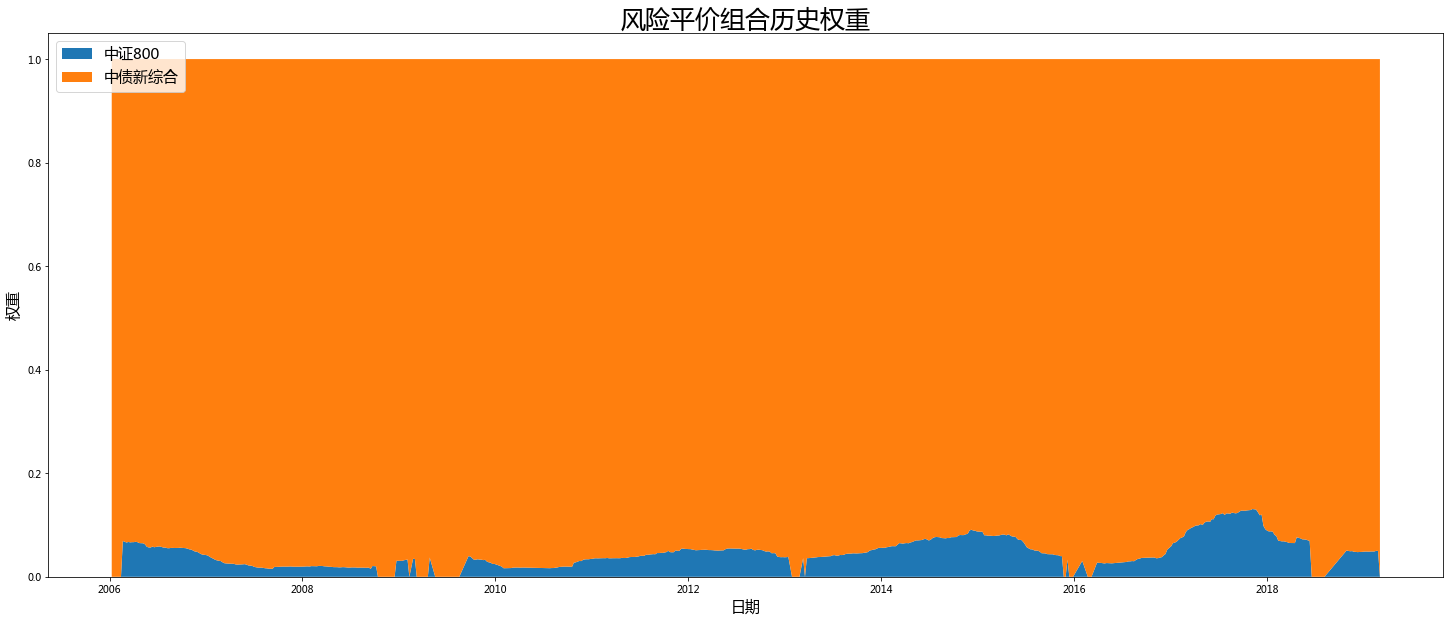

In [116]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['000906.SH'],
                 weight_plot['CBA00101.CS'], 
                 labels=[u'中证800', u'中债新综合'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/stock-bond-base_portfolio_weight.jpg', dpi=200, bbox_inches='tight')

In [117]:
metric(portfolio_ret)

Annual return: 4.97%
Sharpe ratio: 2.37
Annual volatility: 1.62%
Max drawdown: -3.64%


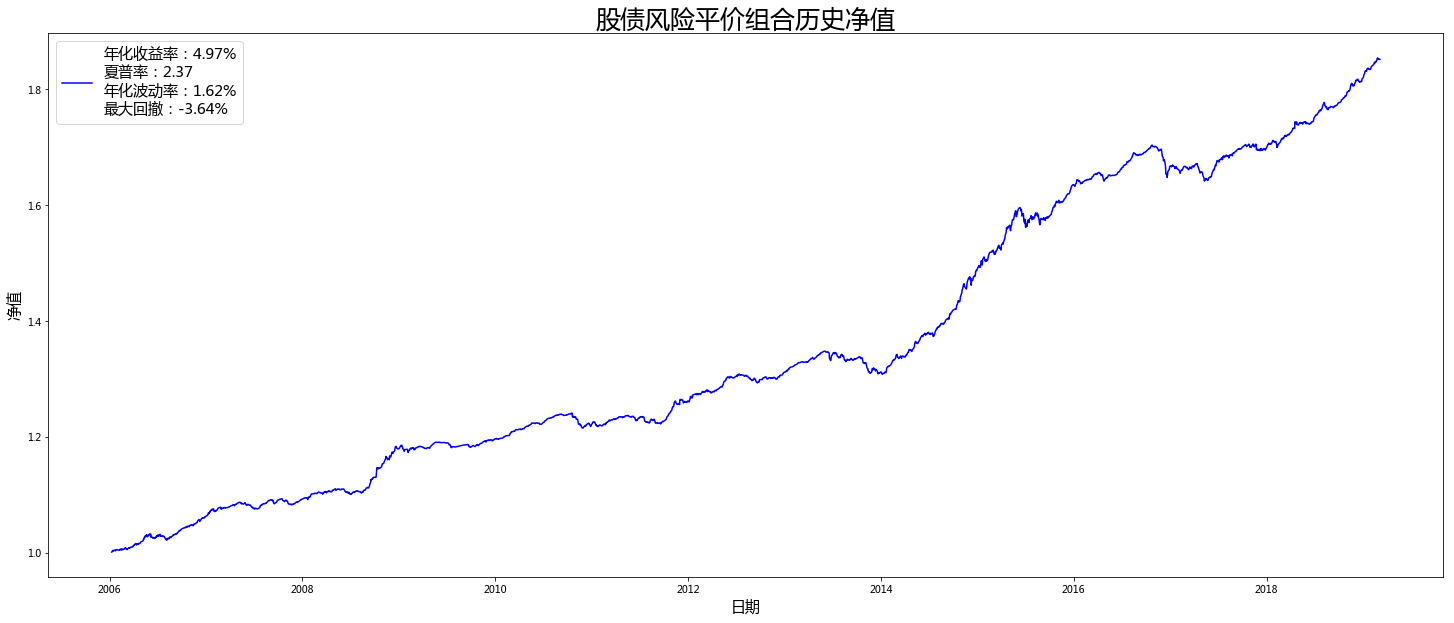

In [119]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue', 
        label=u'年化收益率：4.97%\n夏普率：2.37\n年化波动率：1.62%\n最大回撤：-3.64%')
ax.set_title(u'股债风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
ax.legend(loc='upper left', fontsize=15)
fig.savefig('../pic/stock-bond-base_portfolio_return.jpg', dpi=200, bbox_inches='tight')

# 今年以来风险平价组合与各类资产情况

In [120]:
fname = u'../data/stock-bond-base_stats.xlsx'

In [121]:
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

In [122]:
col_format = workbook.add_format({'bold': True, 'align': 'center', 'font_name': u'楷体', 'font_color': '#FFFFFF', 'bg_color': '#993333'})
cell_format = workbook.add_format({'font_name': u'楷体'})
percent_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00%'})
number_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00'})

In [123]:
worksheet.write('A1', '', col_format)
worksheet.write('B1', u'收益率(周)', col_format)
worksheet.write('C1', u'收益率(月)', col_format)
worksheet.write('D1', u'收益率(年)', col_format)
worksheet.write('E1', u'波动率(年)', col_format)
worksheet.write('F1', u'夏普率(年)', col_format)
worksheet.write('G1', u'当前权重', col_format)
worksheet.write('H1', u'风险贡献', col_format)

0

In [124]:
weights = weight.iloc[-1]

In [125]:
worksheet.write('A2', u'中证800', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['000906.SH']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['000906.SH']
rc = assets_risk_budget[0]
worksheet.write('B2', retw, percent_format)
worksheet.write('C2', retm, percent_format)
worksheet.write('D2', ret, percent_format)
worksheet.write('E2', vol, percent_format)
worksheet.write('F2', sh, number_format)
worksheet.write('G2', w, percent_format)
worksheet.write('H2', rc, percent_format)

0

In [126]:
worksheet.write('A3', u'中债新综合', cell_format)
s = ret_df[ret_df.index >= '2019-01-01']['CBA00101.CS']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
w = weights['CBA00101.CS']
rc = assets_risk_budget[1]
worksheet.write('B3', retw, percent_format)
worksheet.write('C3', retm, percent_format)
worksheet.write('D3', ret, percent_format)
worksheet.write('E3', vol, percent_format)
worksheet.write('F3', sh, number_format)
worksheet.write('G3', w, percent_format)
worksheet.write('H3', rc, percent_format)

0

In [127]:
worksheet.write('A4', u'现金', cell_format)
s = odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change()
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = empyrical.cum_returns_final(s) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B4', retw, percent_format)
worksheet.write('C4', retm, percent_format)
worksheet.write('D4', ret, percent_format)
worksheet.write('E4', vol, percent_format)
worksheet.write('F4', sh, number_format)
worksheet.write('G4', 0, percent_format)
worksheet.write('H4', 0, percent_format)

0

In [128]:
worksheet.write('A5', u'风险平价组合', cell_format)
s = portfolio_ret[portfolio_ret.index >= '2019-01-01']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
# sh = (empyrical.cum_returns_final(s) - 
#      empyrical.cum_returns_final(odf[odf.index >= '2019-01-01']['H11025.CSI'].pct_change())) / vol
sh = empyrical.sharpe_ratio(s, risk_free=0.015/365)
worksheet.write('B5', retw, percent_format)
worksheet.write('C5', retm, percent_format)
worksheet.write('D5', ret, percent_format)
worksheet.write('E5', vol, percent_format)
worksheet.write('F5', sh, number_format)
worksheet.write('G5', 1, percent_format)
worksheet.write('H5', 1, percent_format)

0

In [129]:
worksheet.set_column(0, 0, 15)

0

In [130]:
workbook.close()